# Data Understanding

Proses ini dilakukan untuk memahami data yang terdapat pada dataset-dataset yang terdapat pada MovieLens 20M.
Dataset MovieLens 20M terdiri dari 6 file utama:
- ```movie.csv``` (27278 baris): metadata film
- ```rating.csv``` (20000263 baris): interaksi user–film
- ```tag.csv``` (465564 baris): tag dari user
- ```link.csv```(27278 baris): berisi identifier link di sumber lain
- ```genome_scores.csv``` (11709768 baris): nilai relevansi tags
- ```genome_tags.csv``` (1128 baris): deskripsi tags

Fitur penting:
- ```movieId```: ID film unik
- ```title```: judul film
- ```genres```: genre film (dipisahkan oleh '|')
- ```userId```: ID user
- ```rating```: nilai rating user (0.5-5.0)
- ```tag```: anotasi pendek dari user
- ```timestamp```: waktu interaksi dalam format UNIX time (baik di rating maupun tag)

Fitur tambahan:
- `imdbId` : identifier (kode unik) sumber film di Internet Movie Database ID
- `tmdbId` : identifier (kode unik) sumber film di The Movie Database ID
- `relevance` : nilai relevansi tag terhadap film
- `tagId` : ID unik tag

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alvinaaulianisa","key":"563f61499ee8701869000c7e54afaccf"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d grouplens/movielens-20m-dataset
!unzip movielens-20m-dataset.zip -d movielens-dataset

Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset
License(s): unknown
 57% 111M/195M [00:00<00:00, 1.16GB/s]
100% 195M/195M [00:00<00:00, 832MB/s] 
Archive:  movielens-20m-dataset.zip
  inflating: movielens-dataset/genome_scores.csv  
  inflating: movielens-dataset/genome_tags.csv  
  inflating: movielens-dataset/link.csv  
  inflating: movielens-dataset/movie.csv  
  inflating: movielens-dataset/rating.csv  
  inflating: movielens-dataset/tag.csv  


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [4]:
tags = pd.read_csv('movielens-dataset/tag.csv')
rating = pd.read_csv('movielens-dataset/rating.csv')
movie = pd.read_csv('movielens-dataset/movie.csv')
link = pd.read_csv('movielens-dataset/link.csv')
genome_scores = pd.read_csv('movielens-dataset/genome_scores.csv')
genome_tags = pd.read_csv('movielens-dataset/genome_tags.csv')

In [5]:
print('Jumlah baris tags: ', len(tags.userId))
print('Jumlah baris rating: ', len(rating.userId))
print('Jumlah baris movie: ', len(movie.movieId))
print('Jumlah baris link: ', len(link.movieId))
print('Jumlah baris genome_scores: ', len(genome_scores.movieId))
print('Jumlah baris genome_tags: ', len(genome_tags.tagId))

Jumlah baris tags:  465564
Jumlah baris rating:  20000263
Jumlah baris movie:  27278
Jumlah baris link:  27278
Jumlah baris genome_scores:  11709768
Jumlah baris genome_tags:  1128


In [6]:
print('Jumlah data unik tags: ', len(tags.userId.unique()))
print('Jumlah data unik rating: ', len(rating.userId.unique()))
print('Jumlah data unik movie: ', len(movie.movieId.unique()))
print('Jumlah data unik link: ', len(link.movieId.unique()))
print('Jumlah data unik genome_scores: ', len(genome_scores.movieId.unique()))
print('Jumlah data unik genome_tags: ', len(genome_tags.tagId.unique()))

Jumlah data unik tags:  7801
Jumlah data unik rating:  138493
Jumlah data unik movie:  27278
Jumlah data unik link:  27278
Jumlah data unik genome_scores:  10381
Jumlah data unik genome_tags:  1128


**Insight:**
- Berdasarkan hasil di atas terdapat 7801 data unik pada DataFrame tags dengan total baris 465564, 138493 data unik pada rating dengan total baris 20000263, 27278 data unik pada DataFrame movie dengan total baris 27278, 27278 data unik pada DataFrame link dengan total baris 27278, 10381 data unik pada DataFrame genome_scores dengan total baris 11709768, dan 1128 data unik pada DataFrame genome_tags dengan total baris 1128.

# Univariate Exploratory Data Analysis

- Pada tahap ini dilakukan pemahaman tentang data yang akan diolah, manakah dataframe yang cocok untuk digunakan pada Content-Based Filtering dan Collaborative Filtering.
- Relevansi terhadap kedua teknik filtering. Pada **Content-Based Filtering** hanya membutuhkan data deskripsi item (film) seperti genre dan tag, dan itu sudah cukup dengan movie.csv + tag.csv:
  * **movie.csv**: ```movieId```, ```title```, ```genres```.
  * **tag.csv**: ```userId```, ```movieId```, ```tag```, ```timestamp```.

  Dan untuk **Collaborative Filtering** hanya membutuhkan data user, item, rating dan itu sudah cukup dengan menggunakan rating.csv yang berisi features ```userId```, ```movieId```, ```rating```, ```timestamp```.
- Tiga dataset (```movie.csv```, ```tag.csv```, dan ```rating.csv```) sudah cukup dan optimal untuk membangun sistem rekomendasi dengan dua pendekatan utama (content-based dan collaborative). Dataset lainnya opsional untuk peningkatan performa dan fitur lanjutan.

## Movie

In [ ]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


- Berdasarkan data di atas, dataframe movie memiliki 27278 data yang terdiri dari 3 features yaitu movieId, title, dan genres.

In [ ]:
print('Banyak data movie: ', len(movie.movieId.unique()))
print('Banyak data judul unik: ', len(movie.title.unique()))
print('Banyak data genres: ', len(movie.genres.unique()))

Banyak data movie:  27278
Banyak data judul unik:  27262
Banyak data genres:  1342


- Berdasarkan hasil di atas, pada dataframe movie terdapat 27278 data movie dengan 272762 judul unik dan 1342 genres.

In [ ]:
print('Distribusi: ', movie['genres'].value_counts())

Distribusi:  genres
Drama                                      4520
Comedy                                     2294
Documentary                                1942
Comedy|Drama                               1264
Drama|Romance                              1075
                                           ... 
Action|Mystery|Romance|Western                1
Adventure|Children|Comedy|Drama|Fantasy       1
Animation|Comedy|Horror                       1
Adventure|Crime|Mystery|Romance               1
Adventure|Children|Documentary|Drama          1
Name: count, Length: 1342, dtype: int64


- Hasil distribusi di atas menunjukkan bahwa Drama adalah genre dengan total movie paling banyak yaitu 4520.

## Tags

In [ ]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     465564 non-null  int64 
 1   movieId    465564 non-null  int64 
 2   tag        465548 non-null  object
 3   timestamp  465564 non-null  object
dtypes: int64(2), object(2)
memory usage: 14.2+ MB


- Berdasarkan data di atas, terdapat 465564 total data dengan 4 features yaitu userId, movieId, tag, dan timestamp.

In [ ]:
print('Banyak data tags:', len(tags.tag.unique()))
print('Banyak data user pemberi tags: ', len(tags.userId.unique()))
print('Banyak data movie yang diberi tags: ', len(tags.movieId.unique()))

Banyak data tags: 38644
Banyak data user pemberi tags:  7801
Banyak data movie yang diberi tags:  19545


- Berdasarkan hasil di atas terdapat 38644 data unik pada tags, 7801 data user yang memberikan tags, dan 19545 data movie yang diberi tags.

In [ ]:
print('Distribusi: ', tags['tag'].value_counts())

Distribusi:  tag
sci-fi                 3384
based on a book        3281
atmospheric            2917
comedy                 2779
action                 2657
                       ... 
Diamond Dallas Page       1
I'm Devon Butler!         1
No arguement              1
Really Bad                1
Botox                     1
Name: count, Length: 38643, dtype: int64


- Berdasarkan hasil distribusi di atas diketahui bahwa sci-fi adalah tag dengan movie terbanyak yaitu sejumlah 3384, yang disusul oleh based on a book dengan total movie 3281, dan lain-lain.

## Rating

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


- Berdasarkan hasil di atas diketahui bahwa total data pada dataframe rating adalah 20000263 dengan 4 features yaitu userId, movieId, rating, dan timestamp.

In [ ]:
print('Banyak data user pemberi rating: ', len(rating.userId.unique()))
print('Banyak data movie yang diberi rating: ', len(rating.movieId.unique()))

Banyak data user pemberi rating:  138493
Banyak data movie yang diberi rating:  26744


- Berdasarkan hasil di atas ketahui bahwa terdapat 138493 user yang telah memberi rating pada movie dan terdapat 26744 data movie yang telah diberikan rating.

In [ ]:
print('Distribusi: ', rating['rating'].value_counts().head(10))

Distribusi:  rating
4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: count, dtype: int64


- Berdasarkan hasil distribusi di atas dapat diketahui bahwa sebagian besar user memberikan rating sebesar 4.0/5 dengan total yang telah memberikan rating 4.0 adalah 5561926. Di susul dengan rating 3.0/5 dengan banyak user 4291193, dan rating tertinggi yaitu 5.0 diberikan oleh sebanyak 2898660 user.

## Link

In [ ]:
link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   imdbId   27278 non-null  int64  
 2   tmdbId   27026 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 639.5 KB


- Berdasarkan hasil di atas terdapat 27278 total data yang terdapat pada dataframe link dengan 3 features yang terdiri dari movieId, imdbId, dan terakhir dengan jumlah data yang berbeda yaitu sebanyak 27026 adalah tmdbId.

In [ ]:
print('Banyak data ID unik movie di IMD: ', len(link.imdbId.unique()))
print('Banyak data ID unik movie di TMDB: ', len(link.tmdbId.unique()))

Banyak data ID unik movie di IMD:  27278
Banyak data ID unik movie di TMDB:  27009


- Berdasarkan hasil di atas terdapat total 27278 data unik yang terdapat pada feature imdbId dan 27009 data unik pada feature tmdbId.

## Genome Scores

In [ ]:
genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB


- Berdasarkan data di atas terdapat total sejumlah 11709768 data entries pada dataframe genome_scores yang terdiri dari 3 features yaitu movieId, tagId, dan feature relevance.

In [ ]:
print('Distribusi 10 nilai relevansi paling banyak: ', genome_scores['relevance'].value_counts().head(10))

Distribusi 10 nilai relevansi paling banyak:  relevance
0.01400    37940
0.01275    37920
0.01325    37823
0.01250    37820
0.01225    37812
0.01450    37798
0.01300    37764
0.01125    37755
0.01425    37737
0.01175    37624
Name: count, dtype: int64


- Berdasarkan hasil distribusi di atas nilai relevansi yang paling banyak dimiliki oleh movie adalah sebesar 0.01400 yang mana ini berarti sebanyak 37940 tags memiliki nilai relevansi yang cukup baik daripada yang lainnya (biasanya semakin menyentuh angka 1 maka relevansi semakin baik). Dari hasil tersebut terlihat bahwa nilai relevansi yang paling tinggi adalah sebesar 0.0450 dengan nilai 0.01125 sebagai nilai relevansi yang paling kecil.

## Genome Tags

In [ ]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


- Berdasarkan hasil di atas diketahui bahwa terdapat 1128 total baris yang ada pada dataframe genome_tags dengan 2 features yaitu tagId dan tag.

In [ ]:
genome_tags['tag'].head(10)

,tag
0,007
1,007 (series)
2,18th century
3,1920s
4,1930s
5,1950s
6,1960s
7,1970s
8,1980s
9,19th century


# Data Preparation

Tahap ini dilakukan untuk menyiapkan data seperti penanganan missing value, duplikasi, penggabungan feature yang diperlukan, hingga split data train dan validation sebelum digunakan dalam Content-Based Filtering dan Collaborative Filtering agar hasil rekomendasi yang diberikan dapat efektif.

## Mengatasi Missing Value

Proses ini dilakukan untuk menghilangkan nilai yang hilang yang akan berpengaruh buruk pada hasil rekomendasi pada CBF maupun Collaborative Filtering.

### tags

In [7]:
tags.isna().sum()

,0
userId,0
movieId,0
tag,16
timestamp,0


**Insight:**
- Terdapat sebanyak 16 data yang bernilai NaN atau null, dan karena data null ini terbilang masih sangat sedikit dibandingkan dengan total data keseluruhan maka akan lebih baik jika nilai NaN itu dihapus.

In [8]:
tags.dropna(subset=['tag'], inplace=True)

In [9]:
tags.isna().sum()

,0
userId,0
movieId,0
tag,0
timestamp,0


- Kini sudah tidak ada missing value.

### rating

In [10]:
rating.isna().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


**Insight:** Tidak ada missing values.

## Mengatasi Duplikasi

Tahap ini dilakukan untuk mendeteksi dan mengatasi duplikasi yang nanti akan berpengaruh pada hasil rekomendasi.

In [11]:
tags.duplicated().sum()

np.int64(0)

In [12]:
tags.shape

(465548, 4)

In [13]:
rating.shape

(20000263, 4)

**Insight:**
- DataFrame movies_tags berisi 19545 data dengan 5 features dan DataFrame rating memiliki 20.000.263 data dengan 4 features.

## Agregasi data berdasarkan movieId

In [ ]:
movie_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

- Melakukan pengelompokan (grouping) dan penggabungan (aggregation) data berdasarkan movieId.

## Penggabungan Tag per Film

Proses ini digunakan untuk mempersiapkan data teks (genre dan tag) dari film agar siap diolah dalam model Content-Based Filtering.

In [14]:
movies_tags = pd.merge(movie, movie_tags, on='movieId', how='left')
movies_tags['combined'] = movies_tags['genres'].str.replace('|', ' ') + ' ' + movies_tags['tag'].fillna('')

In [17]:
movies_tags.head()

,movieId,title,genres,tag,combined
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Watched computer animation Disney animated fea...,Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,time travel adapted from:book board game child...,Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,old people that is actually funny sequel fever...,Comedy Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,chick flick revenge characters chick flick cha...,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...,Comedy


**Insight:**
- feature ```movies_tags['combined']``` adalah feature yang berisi gabungan data dari feature ```movies_tags['genres']``` dan juga ```movies_tags['tag']```.
- Tujuan dari operasi ini adalah untuk membuat data siap diolah menggunakan TF-IDF dan penggabungan ini dapat memperkaya film karena genre memberikan informasi umum tentang film dan tag memberikan deskripsi lebih spesifik dari pengguna.

## TF-IDF Vectorizer

Proses ini digunakan untuk mengubah teks (genre + tag film) menjadi representasi numerik menggunakan teknik TF-IDF (Term Frequency-Inverse Document Frequency), sehingga bisa dihitung kemiripannya (cosine similarity) untuk sistem rekomendasi berbasis konten (Content-Based Filtering).

In [ ]:
movie_tags_copy = movies_tags.copy()

In [ ]:
movie_tags_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19545 entries, 0 to 27275
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movieId   19545 non-null  int64 
 1   title     19545 non-null  object
 2   genres    19545 non-null  object
 3   tag       19545 non-null  object
 4   combined  19545 non-null  object
dtypes: int64(1), object(4)
memory usage: 916.2+ KB


In [ ]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(movie_tags_copy['combined'])

In [ ]:
tfidf_matrix.shape

(19545, 5000)

**Insight:** Dataset ini terdiri dari 19.545 film dan dari kolom 'combined' (kombinasi dat pada features genres dan tags) TF-IDF Vectorizer menghasilkan 23.865 kata unik setelah stop words dihapus.

## Pengambilan Data Sampel Rating

In [ ]:
rating.shape

(20000263, 4)

Dataset yang ada pada DataFrame rating terlalu banyak (20.000.263), sehingga menurut saya akan lebih baik jika menggunakan jumlah data ideal (2000.000, 10% dari data total) dari dataset tersebut agar model train dilakukan dengan lebih efisien namun tetap memberikan performa yang baik.

In [ ]:
ratings = rating.copy()

In [ ]:
ratings = ratings.sample(2000_000, random_state=42)

In [ ]:
ratings.shape

(2000000, 4)

Jumlah dataset berhasil diperkecil dengan hanya mengambil 10% (2000.000) data dari data keseluruhan, yaitu 20.000.263

## Encode userId dan movieId

Pada tahap ini melakukan preprocessing data rating untuk mempersiapkan input yang dibutuhkan oleh model Collaborative Filtering (filter kolaboratif)

In [ ]:
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()

user_to_idx = {user: idx for idx, user in enumerate(user_ids)}
movie_to_idx = {movie: idx for idx, movie in enumerate(movie_ids)}

In [ ]:
x_user = np.array([user_to_idx[u] for u in ratings['userId']], dtype=np.int32)
x_movie = np.array([movie_to_idx[m] for m in ratings['movieId']], dtype=np.int32)

min_rating, max_rating = ratings['rating'].min(), ratings['rating'].max()
y = ((ratings['rating'].values - min_rating) / (max_rating - min_rating)).astype(np.float32)

x = np.column_stack((x_user, x_movie))

## Membagi Data untuk Training dan Validasi (Collaborative Filtering)

In [ ]:
indices = np.random.permutation(len(x))
train_size = int(0.8 * len(x))
train_idx, val_idx = indices[:train_size], indices[train_size:]

x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(10000).batch(128).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
print(f"Total data: {len(x)}")
print(f"Data training: {len(x_train)} ({len(x_train)/len(x)*100:.1f}%)")
print(f"Data validation: {len(x_val)} ({len(x_val)/len(x)*100:.1f}%)")

Total data: 2000000
Data training: 1600000 (80.0%)
Data validation: 400000 (20.0%)


**Insight:**
- Dataset sampel sudah berhasil di split menjadi data training dan data validation dengan perbandingan 80:20.
- 80% dari 2000.000 data digunakan sebagai data training (160.000)
- 20% dari 2000.000 data digunakan sebagai data validation (40.000)

# Model Development Content Based Filtering

Content-Based Filtering merekomendasikan item berdasarkan kesamaan fitur dengan item yang disukai pengguna di masa lalu. Misalnya, jika Anda sering menonton film sci-fi seperti Interstellar, sistem akan menganalisis genre, sutradara, atau aktor dari film tersebut, lalu merekomendasikan film sci-fi lain seperti The Martian. Kelebihannya: cocok untuk cold start problem (item/user baru), tapi terbatas pada rekomendasi serupa (kurang beragam).

## Cosine Similarity

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=movie_tags_copy['title'], columns=movie_tags_copy['title'])

In [ ]:
cosine_sim_df.head()

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Santo vs. las lobas (1976),Execution Squad (1972),Get Hard (2015),Hellgate (2011),La liga no es cosa de hombres (1972),Dinotopia: Quest for the Ruby Sunstone (2005),Playground (2009),Vietnam in HD (2011),Parallels (2015),The Pirates (2014)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.064998,0.015458,0.003731,0.026791,0.007177,0.001084,0.030547,0.000772,0.007923,...,0.011363,0.001056,0.012319,0.000000,0.0,0.038200,0.0,0.0,0.0,0.013277
Jumanji (1995),0.064998,1.000000,0.001309,0.042097,0.017822,0.000593,0.023073,0.077693,0.013997,0.002351,...,0.041536,0.000000,0.000000,0.012941,0.0,0.097744,0.0,0.0,0.0,0.006270
Grumpier Old Men (1995),0.015458,0.001309,1.000000,0.036096,0.124356,0.000870,0.031252,0.000000,0.005531,0.012759,...,0.000000,0.000000,0.042826,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
Waiting to Exhale (1995),0.003731,0.042097,0.036096,1.000000,0.017325,0.001183,0.360625,0.000000,0.007523,0.007683,...,0.000000,0.065383,0.029124,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
Father of the Bride Part II (1995),0.026791,0.017822,0.124356,0.017325,1.000000,0.000552,0.047675,0.000000,0.003514,0.006429,...,0.017174,0.000000,0.027204,0.000000,0.0,0.018525,0.0,0.0,0.0,0.000000


- Kode tersebut menghitung kemiripan antar film berdasarkan representasi TF-IDF dari genre dan tag, menggunakan cosine similarity.
- Diagonal (1.000000): Setiap film memiliki kemiripan sempurna dengan dirinya sendiri.

- Nilai Off-Diagonal:
  * Toy Story vs Jumanji: 0.064998 → Kemiripan rendah (meski sama-sama film anak, genre/tag-nya berbeda).
  * Waiting to Exhale vs Sabrina: 0.360625 → Kemiripan cukup tinggi (mungkin karena genre romance/drama).
  * Nilai 0.000000: Tidak ada kemiripan (tidak ada term yang sama di TF-IDF).

## Mendapatkan Rekomendasi

In [ ]:
def movie_recommendations(title, k=5):
    if title not in cosine_sim_df:
        return f"Movie '{title}' not found."
    sim_scores = cosine_sim_df[title].sort_values(ascending=False).iloc[1:k+1]
    return sim_scores

print("Film yang direkomendasikan berdasarkan content pilihan:")
movie_recommendations("Toy Story (1995)")

Film yang direkomendasikan berdasarkan content pilihan:


,Toy Story (1995)
title,
Toy Story 2 (1999),0.925746
"Bug's Life, A (1998)",0.825143
Ice Age (2002),0.759788
"Monsters, Inc. (2001)",0.747811
Toy Story 3 (2010),0.720269


**Insight:**
- Rekomendasi sangat relevan karena semua film yang direkomendasikan adalah animasi dari genre yang sama (family/animasi) dan Toy Story 2 sebagai sekuel langsung mendapatkan skor tertinggi (0.936), yang sangat masuk akal.
- Skor kesamaan cukup tinggi (>0.76) untuk semua rekomendasi yang menunjukkan bahwa film-film ini memiliki banyak kesamaan dengan Toy Story. Namun ada penurunan skor yang gradual dari rekomendasi pertama ke kelima yang menunjukkan variasi dalam tingkat kesamaan.

## Evaluasi Precision@K, Recall@K, dan NDCG@K

In [ ]:
import numpy as np

def ndcg_at_k(relevance_scores, k):
    dcg = 0.0
    for i in range(k):
        rel = relevance_scores[i]
        dcg += (2**rel - 1) / np.log2(i + 2)
    ideal = sorted(relevance_scores, reverse=True)
    idcg = 0.0
    for i in range(min(k, len(ideal))):
        idcg += (2**ideal[i] - 1) / np.log2(i + 2)
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_cbf_average(k=5, n_users=50):
    precision_list = []
    recall_list = []
    ndcg_list = []

    users = ratings['userId'].drop_duplicates().sample(n_users, random_state=42)

    for user_id in users:
        user_movies = ratings[ratings['userId'] == user_id]
        top_rated = user_movies[user_movies['rating'] >= 4.0]['movieId'].tolist()
        if not top_rated:
            continue

        sample_movie_id = top_rated[0]
        title_row = movies_tags[movies_tags['movieId'] == sample_movie_id]
        if title_row.empty:
            continue

        sample_title = title_row['title'].values[0]
        recs = movie_recommendations(sample_title, k=k)
        rec_titles = recs.index.tolist()

        watched_titles = movies_tags[movies_tags['movieId'].isin(user_movies['movieId'])]['title'].tolist()
        relevance = [1 if title in watched_titles else 0 for title in rec_titles]

        precision = sum(relevance) / k
        recall = sum(relevance) / len(watched_titles) if watched_titles else 0
        ndcg = ndcg_at_k(relevance, k)

        precision_list.append(precision)
        recall_list.append(recall)
        ndcg_list.append(ndcg)

    print(f"Evaluasi rata-rata untuk {len(precision_list)} user:")
    print(f"Average Precision@{k}: {np.mean(precision_list):.4f}")
    print(f"Average Recall@{k}: {np.mean(recall_list):.4f}")
    print(f"Average NDCG@{k}: {np.mean(ndcg_list):.4f}")

In [ ]:
evaluate_cbf_average(k=10, n_users=100)

Evaluasi rata-rata untuk 90 user:
Average Precision@10: 0.0044
Average Recall@10: 0.0061
Average NDCG@10: 0.0171


**Insight:**
- Average Precision@10 bernilai 0.0044 yang artinya dari 10 film yang direkomendasikan, hanya sekitar 0.044 (4.4%) yang pernah ditonton oleh user.
- Average Recall@10 bernilai 0.0061 yang artinya dari semua film yang pernah ditonton oleh user, hanya sekitar 0.61% yang berhasil direkomendasikan oleh sistem (dalam 10 film teratas).
- Average NDCG@10 bernilsi 0.0171 yang artinya urutan rekomendasi kamu hampir tidak relevan dengan minat user. Nilai NDCG ideal = 1.0 jika semua film yang direkomendasikan adalah film yang disukai user, diurutkan dengan baik.

Berdasarkan hasil di atas, dapat disimpulkan bahwa sistem Content-Based Filtering memang tidak dibangun untuk mencerminkan histori secara langsung karena tujuannya adalah untuk menemukan film baru yang mirip dengan yang disukai user sebelumnya bukan mereplikasi histori.

# Model Development dengan Collaborative Filtering

Collaborative Filtering bekerja dengan memanfaatkan perilaku pengguna lain yang mirip. Misalnya, jika Anda dan User A sama-sama menyukai Inception dan The Dark Knight, lalu User A menyukai Tenet, sistem akan merekomendasikan Tenet kepada Anda—tanpa perlu tahu genre filmnya. Kelebihannya: bisa menemukan pola tak terduga, tapi rentan terhadap sparsity data dan cold start.

## Proses Training

In [ ]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size=32):
        super().__init__()
        initializer = tf.keras.initializers.GlorotNormal()

        self.user_embedding = layers.Embedding(
            num_users, embedding_size,
            embeddings_initializer=initializer,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))

        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movies, embedding_size,
            embeddings_initializer=initializer,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))

        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vec = self.user_embedding(inputs[:, 0])
        movie_vec = self.movie_embedding(inputs[:, 1])
        user_bias = self.user_bias(inputs[:, 0])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot = tf.reduce_sum(user_vec * movie_vec, axis=1, keepdims=True)
        return tf.nn.sigmoid(dot + user_bias + movie_bias)

model = RecommenderNet(len(user_ids), len(movie_ids), embedding_size=32)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1004s 80ms/step - loss: 0.6419 - root_mean_squared_error: 0.2418 - val_loss: 0.6049 - val_root_mean_squared_error: 0.2025 - learning_rate: 0.0010
Epoch 2/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1039s 80ms/step - loss: 0.6010 - root_mean_squared_error: 0.1984 - val_loss: 0.5996 - val_root_mean_squared_error: 0.1975 - learning_rate: 0.0010
Epoch 3/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 986s 79ms/step - loss: 0.5950 - root_mean_squared_error: 0.1926 - val_loss: 0.5977 - val_root_mean_squared_error: 0.1960 - learning_rate: 0.0010
Epoch 4/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1016s 81ms/step - loss: 0.5919 - root_mean_squared_error: 0.1897 - val_loss: 0.5969 - val_root_mean_squared_error: 0.1954 - learning_rate: 0.0010
Epoch 5/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1012s 81ms/step - loss: 0.5899 - root_mean_squared_error: 0.1878 - val_loss: 0.5966 - val_root_mean_squared_error: 0.1952 - learning_rate: 0.0010
Epoch 6/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 993s 79

## Visualisasi Metrik

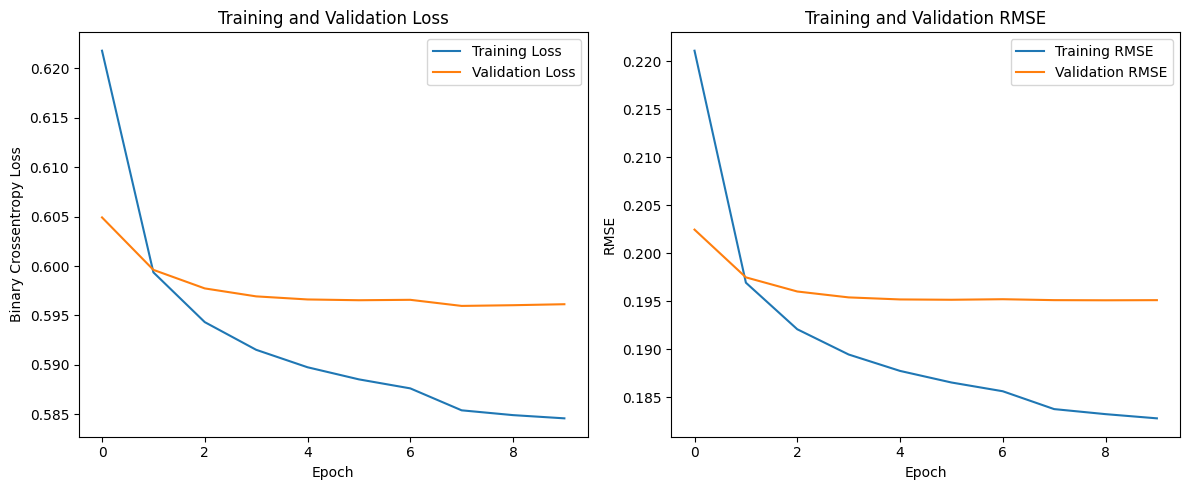

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('Training and Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_training_history(history)

**Insight:**
- Epoch 0 hingga 1 mengalami penurunan loss yang tajam yang menunjukkan model belajar dengan cepat pada awal pelatihan. Epoch 2 hingga 5 penurunan loss menjadi lebih landai (melambat) yang menunjukkan model mulai mencapai stabilisasi. Dan pada epoch 6 hingga 9 training Loss terus menurun sedikit demi sedikit, validation loss mulai stagnan bahkan cenderung datar pada level sekitar 0.596.
- Validation loss tidak mengalami kenaikan yang signifikan, tidak ada overfitting, tapi juga tidak banyak perbaikan setelah epoch ke-5 dan ini menandakan bahwa model sudah mencapai titik optimal relatif terhadap kompleksitas dan jumlah data yang digunakan.
- RMSE Train menurun dari > 0.22 ke ~0.183 secara konsisten yang menunjukkan peningkatan akurasi prediksi pada data training. RMSE Val menurun dari ~0.202 ke ~0.195 dan kemudian stagnan setelah epoch ke-4.
- Penurunan RMSE menunjukkan bahwa model semakin baik dalam memprediksi nilai rating yang mendekati aktual. Gap kecil antara Training dan Validation RMSE menunjukkan bahwa model tidak mengalami overfitting dan generalisasi cukup baik terhadap data baru.

## Mendapatkan Rekomendasi

In [ ]:
def show_recommendations(user_id, n=10):
    if user_id not in user_to_idx:
        print(f"User {user_id} tidak ditemukan")
        return

    watched = ratings[ratings['userId'] == user_id]['movieId'].unique()
    unwatched = list(set(movie_ids) - set(watched))

    user_array = np.array([user_to_idx[user_id]] * len(unwatched))
    movie_array = np.array([movie_to_idx[m] for m in unwatched])
    input_array = np.column_stack((user_array, movie_array))

    ratings_pred = model.predict(input_array, batch_size=1024, verbose=0).flatten()
    ratings_pred = ratings_pred * (max_rating - min_rating) + min_rating

    recommendations = pd.DataFrame({
        'movieId': unwatched,
        'predicted_rating': ratings_pred
    }).merge(movie, on='movieId')

    print(f"\nTop {n} Rekomendasi untuk User {user_id}:")
    display(recommendations.nlargest(n, 'predicted_rating')[['title', 'genres', 'predicted_rating']])

sample_user = ratings['userId'].sample(1).iloc[0]
show_recommendations(sample_user)


Top 10 Rekomendasi untuk User 136903:


,title,genres,predicted_rating
316,"Shawshank Redemption, The (1994)",Crime|Drama,4.148845
665,"World of Apu, The (Apur Sansar) (1959)",Drama,4.102694
8696,Cosmos (1980),Documentary,4.090828
2849,Children of Paradise (Les enfants du paradis) ...,Drama|Romance,4.050789
2287,"Nights of Cabiria (Notti di Cabiria, Le) (1957)",Drama,4.043172
3354,Double Indemnity (1944),Crime|Drama|Film-Noir,4.040033
6879,"Passion of Joan of Arc, The (Passion de Jeanne...",Drama,4.037985
664,Song of the Little Road (Pather Panchali) (1955),Drama,4.027080
49,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.024944
851,"Godfather, The (1972)",Crime|Drama,4.020790


**Insight:**
- Semua film yang direkomendasikan memiliki prediksi rating di atas 4.0 (skala maksimal 5.0) yang menunjukkan bahwa model yakin user akan sangat menyukai film-film ini.
- Rentang prediksi rating cukup ketat (4.02–4.15) yang artinya model kesulitan menentukan prioritas teratas karena semua rekomendasi dianggap sangat relevan.
- Drama mendominasi (8/10 film) dengan kombinasi genre seperti Crime (The Godfather, The Shawshank Redemption), Romance (Children of Paradise), atau Film-Noir (Double Indemnity). Ada juga film non-Drama seperti dokumenter (Cosmos) dan thriller (The Usual Suspects).